In [94]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Add fieldnames to the data to make array adressing easier
fieldnames =  ['id','radius','texture','perimeter',  
        'area', 'smoothness', 'compactness',
        'concavity', 'concave_point', 'symmetry','fractal_dimension','diagnosis']
cancer_test = pd.read_csv('data_test.csv', sep=',', names=fieldnames)
cancer_train = pd.read_csv('data_train.csv', sep=',', names=fieldnames)
cancer_testx= cancer_test.drop(columns=['diagnosis'])
cancer_trainx= cancer_train.drop(columns=['diagnosis'])
cancer_train.head() #Overview of the presentation of data in the file


,id,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_point,symmetry,fractal_dimension,diagnosis
0,-0.239443,-0.013303,1.775766,-0.014920,-0.144789,0.228790,0.175467,-0.544402,-0.128256,-1.012054,-0.152706,B
1,0.474359,-0.844828,-0.628428,-0.877027,-0.765610,-1.019821,-1.249059,-0.944554,-0.889091,-1.109505,-0.186165,B
2,-0.239823,1.447559,0.711802,1.474288,1.405424,-0.758582,0.754792,0.319555,0.511737,-0.149990,-1.086665,M
3,-0.246096,-0.081648,0.999483,-0.007498,-0.152149,2.546938,1.407012,0.893973,1.135134,1.664093,1.665752,M
4,-0.239997,-0.896086,0.451519,-0.818069,-0.793920,1.872772,0.351950,0.228993,0.225711,0.329767,0.864176,M


In [95]:
cancer_test.isna() #Checking for missing values

,id,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_point,symmetry,fractal_dimension,diagnosis
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
109,False,False,False,False,False,False,False,False,False,False,False,False
110,False,False,False,False,False,False,False,False,False,False,False,False
111,False,False,False,False,False,False,False,False,False,False,False,False
112,False,False,False,False,False,False,False,False,False,False,False,False


In [96]:
#Encoding diagnosis values from Categorical to Integer Format
cancer_train['diagnosis'] = cancer_train['diagnosis'].replace('B', 0)
cancer_train['diagnosis'] = cancer_train['diagnosis'].replace('M', 1)
cancer_test['diagnosis'] = cancer_test['diagnosis'].replace('B', 0)
cancer_test['diagnosis'] = cancer_test['diagnosis'].replace('M', 1)
#Putting data into 2D-Arrays for train and test datasets
Xtrain = cancer_trainx.values
Ytrain = cancer_train['diagnosis'].values.reshape(cancer_trainx.shape[0], 1) #1D Array for the diagnosis(target) value
Xtest = cancer_testx.values
Ytest =  cancer_test['diagnosis'].values.reshape(cancer_testx.shape[0], 1)

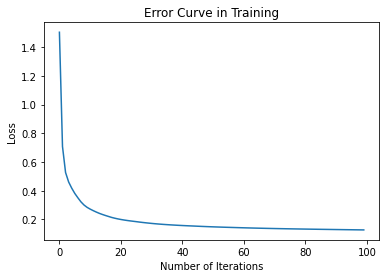

The accuracy during training was 94%
The accuracy during testing was 91%


In [97]:
#Creating the class for Artificial Neural Network consisting of 2 Layers 
class ANN():
    def __init__(self, layers=[11,6,1],learning_rate=0.001, iterations=100):
        self.parameter = {} # Used in order to store the current value of weights and bias
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.layers = layers
                
    def weight_initialization(self):
        np.random.seed(1) # Making sure same numbers are generated on every run
        self.parameter["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.parameter['b1']  =np.random.randn(self.layers[1],)
        self.parameter['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.parameter['b2'] = np.random.randn(self.layers[2],)
    
    def reLu(self,A):
        return np.maximum(0,A) #Values less than zero in the array are set to 0.

    def dRelu(self, x): #Derivative of relu function used in backpropagation
        x[x>0] = 1
        x[x<=0] = 0
        return x

    def zeroError(self, x): # To prevent zero values corrupting our result
      val = 0.0000000001
      return np.maximum(x, val)


    def sigmoid(self,A):
        return 1/(1+np.exp(-A)) #Outputs a real number between 0 and 1

    def binary_entropy(self,y, target): # The cost function
        totalvalues = len(y)
        target_inv = 1.0 - target
        y_inv = 1.0 - y
        target = self.zeroError(target) # To prevent infinity values from LOG later
        target_inv = self.zeroError(target_inv) 
        loss = -1/totalvalues * (np.sum(np.multiply(np.log(target), y) + np.multiply((y_inv), np.log(target_inv)))) #formula
        return loss

    def forward_propagation(self):
        L1 = self.X.dot(self.parameter['W1']) + self.parameter['b1']  #Layer1 Summation
        L11 = self.reLu(L1)                                            #Layer1 Activation: reLu
        L2 = L11.dot(self.parameter['W2']) + self.parameter['b2']      #Layer2 Summation
        target = self.sigmoid(L2) # The predicted value of diagnosis, #layer2 Activation: sigmoid
        loss = self.binary_entropy(self.y,target) # Error in predicted value

        # save calculated parameters     
        self.parameter['L1'] = L1
        self.parameter['L11'] = L11

        return target,loss

    def back_propagation(self,target): #Go backwards taking derivatives and updating weights+bias
        y_inv = 1 - self.y
        target_inv = 1 - target

        dl_target = np.divide(y_inv, self.zeroError(target_inv)) - np.divide(self.y, self.zeroError(target))
        dl_sig = target * (target_inv)
        dl_z2 = dl_target * dl_sig

        dl_A1 = dl_z2.dot(self.parameter['W2'].T)
        dl_w2 = self.parameter['L11'].T.dot(dl_z2)
        dl_b2 = np.sum(dl_z2, axis=0, keepdims=True)

        dl_z1 = dl_A1 * self.dRelu(self.parameter['L1'])
        dl_w1 = self.X.T.dot(dl_z1)
        dl_b1 = np.sum(dl_z1, axis=0, keepdims=True)

        #Changes being made to the weights and bias
        self.parameter['W1'] = self.parameter['W1'] - self.learning_rate * dl_w1
        self.parameter['W2'] = self.parameter['W2'] - self.learning_rate * dl_w2
        self.parameter['b1'] = self.parameter['b1'] - self.learning_rate * dl_b1
        self.parameter['b2'] = self.parameter['b2'] - self.learning_rate * dl_b2

    def train(self, X, y):
        self.X = X
        self.y = y
        self.weight_initialization() #initialize weights and bias
        
        for i in range(self.iterations):
            target, loss = self.forward_propagation()
            self.back_propagation(target)
            self.loss.append(loss)

    def predict(self, data): # Prediction based on test data X
        L1 = data.dot(self.parameter['W1']) + self.parameter['b1'] #Layer1 Summation 
        L11 = self.reLu(L1)                 #Layer1 Activation function
        L2 = L11.dot(self.parameter['W2']) + self.parameter['b2'] #Layer2 Summation
        result = self.sigmoid(L2)            #Layer2 Activation
        return np.round(result) 

    def accuracy(self, actual, target): # Compare actual value and predicted value
        acc = int(sum(actual == target) / len(actual) * 100)
        return acc


    def graph(self):
        plt.plot(self.loss)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt.title("Error Curve in Training")
        plt.show() 
 

cancer = ANN() 
cancer.train(Xtrain, Ytrain)
cancer.graph() #Plot results of training on graph
predict_train = cancer.predict(Xtrain)
predict_test = cancer.predict(Xtest)

print("The accuracy during training was {}%".format(cancer.accuracy(Ytrain, predict_train)))
print("The accuracy during testing was {}%".format(cancer.accuracy(Ytest, predict_test)))